# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
# Deleting all model folders created from previous runs
!find . -type d -name "model*" -exec rm -rf {} +

In [2]:
import numpy as np
import os
import imageio.v2 as imageio
from skimage.transform import resize
import datetime
import matplotlib.pyplot as plt
import os
import keras.layers

We set the random seed so that the results don't vary drastically.

In [3]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())
batch_size = 16 #experiment with the batch size

In [7]:

def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [8]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zca_whitening = True
)

def generator(source_path, folder_list, batch_size, augment=False):
    total_frames = 30
    num_images = 20
    height = 120
    width = 120
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, num_images, height, width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width))
                    
                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output           

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)                          
                    
                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


/Users/abhishek/anaconda3/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1444: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [9]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [10]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

## Models
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [11]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [12]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, GlobalAveragePooling2D, GlobalAveragePooling3D, ZeroPadding3D, BatchNormalization, Activation, Dropout, ConvLSTM2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [13]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}.h5' #-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

### Trial #1

Conv3D

In [15]:
#write your model here
input_shape = (20, 120, 120, 3)

model = Sequential()

model.add(Conv3D(32, (3,3,3), padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, (3, 3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(64, (3, 3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(5))
model.add(Activation('softmax'))

In [16]:
optimiser = optimizers.Adam()#lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 120, 120, 32   2624      
                             )                                   
                                                                 
 batch_normalization (Batch  (None, 20, 120, 120, 32   128       
 Normalization)              )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 10, 60, 60, 32)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 60, 60, 64)    55360     
                                                                 
 batch_normalization_1 (Bat  (None, 10, 60, 60, 64)    256       
 chNormalization)                                       

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [17]:
history_model1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 16


/var/folders/vl/vtj4wvk929l5x6hncfgprdyr0000gn/T/ipykernel_32324/1995094951.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/10

Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-2.86501-0.18750.h5
 1/42 [..............................] - ETA: 6:00 - loss: 2.8650 - categorical_accuracy: 0.1875

/Users/abhishek/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-14.43076-0.25000.h5
 2/42 [>.............................] - ETA: 5:06 - loss: 14.4308 - categorical_accuracy: 0.2500
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-23.97793-0.25000.h5
 3/42 [=>............................] - ETA: 4:54 - loss: 23.9779 - categorical_accuracy: 0.2500
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-22.74439-0.28125.h5
 4/42 [=>............................] - ETA: 4:47 - loss: 22.7444 - categorical_accuracy: 0.2812
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-21.59819-0.27500.h5
 5/42 [==>...........................] - ETA: 4:36 - loss: 21.5982 - categorical_accuracy: 0.2750
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-18.76928-0.32292.h5
 6/42 [===>..........................] - ETA: 4:29 - loss: 18.7693 - categorical_accuracy: 0.3229
Epoch 1: saving model to model_init_202

 1/42 [..............................] - ETA: 5:36 - loss: 1.0064 - categorical_accuracy: 0.5625
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-1.35063-0.50000.h5
 2/42 [>.............................] - ETA: 5:05 - loss: 1.3506 - categorical_accuracy: 0.5000
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-1.39523-0.45833.h5
 3/42 [=>............................] - ETA: 4:52 - loss: 1.3952 - categorical_accuracy: 0.4583
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-1.56289-0.45312.h5
 4/42 [=>............................] - ETA: 4:46 - loss: 1.5629 - categorical_accuracy: 0.4531
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-1.45395-0.45000.h5
 5/42 [==>...........................] - ETA: 4:38 - loss: 1.4540 - categorical_accuracy: 0.4500
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-1.59987-0.45833.h5
 6/42 [===>..........................] - ETA: 4:30

 2/42 [>.............................] - ETA: 5:36 - loss: 0.9366 - categorical_accuracy: 0.5625
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-1.02896-0.50000.h5
 3/42 [=>............................] - ETA: 5:12 - loss: 1.0290 - categorical_accuracy: 0.5000
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-0.95690-0.51562.h5
 4/42 [=>............................] - ETA: 5:02 - loss: 0.9569 - categorical_accuracy: 0.5156
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-0.93436-0.57500.h5
 5/42 [==>...........................] - ETA: 4:52 - loss: 0.9344 - categorical_accuracy: 0.5750
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-1.02857-0.55208.h5
 6/42 [===>..........................] - ETA: 4:41 - loss: 1.0286 - categorical_accuracy: 0.5521
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-1.04962-0.56250.h5
 7/42 [====>.........................] - ETA: 4:30

 3/42 [=>............................] - ETA: 5:19 - loss: 1.2522 - categorical_accuracy: 0.6042
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-1.34849-0.59375.h5
 4/42 [=>............................] - ETA: 5:11 - loss: 1.3485 - categorical_accuracy: 0.5938
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-1.20414-0.61250.h5
 5/42 [==>...........................] - ETA: 4:59 - loss: 1.2041 - categorical_accuracy: 0.6125
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-1.12190-0.62500.h5
 6/42 [===>..........................] - ETA: 4:48 - loss: 1.1219 - categorical_accuracy: 0.6250
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-1.11418-0.62500.h5
 7/42 [====>.........................] - ETA: 4:41 - loss: 1.1142 - categorical_accuracy: 0.6250
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-1.08399-0.63281.h5
 8/42 [====>.........................] - ETA: 4:30

 4/42 [=>............................] - ETA: 4:39 - loss: 0.7962 - categorical_accuracy: 0.7188
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.90529-0.71250.h5
 5/42 [==>...........................] - ETA: 4:31 - loss: 0.9053 - categorical_accuracy: 0.7125
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.84655-0.70833.h5
 6/42 [===>..........................] - ETA: 4:24 - loss: 0.8465 - categorical_accuracy: 0.7083
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.87693-0.70536.h5
 7/42 [====>.........................] - ETA: 4:16 - loss: 0.8769 - categorical_accuracy: 0.7054
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.98435-0.69531.h5
 8/42 [====>.........................] - ETA: 4:09 - loss: 0.9843 - categorical_accuracy: 0.6953
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-1.00476-0.68056.h5
 9/42 [=====>........................] - ETA: 4:02

 5/42 [==>...........................] - ETA: 4:22 - loss: 0.7024 - categorical_accuracy: 0.7375
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.69911-0.71875.h5
 6/42 [===>..........................] - ETA: 4:16 - loss: 0.6991 - categorical_accuracy: 0.7188
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.69713-0.70536.h5
 7/42 [====>.........................] - ETA: 4:09 - loss: 0.6971 - categorical_accuracy: 0.7054
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.69909-0.71094.h5
 8/42 [====>.........................] - ETA: 4:04 - loss: 0.6991 - categorical_accuracy: 0.7109
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.72650-0.70139.h5
 9/42 [=====>........................] - ETA: 3:56 - loss: 0.7265 - categorical_accuracy: 0.7014
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.69542-0.71875.h5
10/42 [======>.......................] - ETA: 3:48

 6/42 [===>..........................] - ETA: 4:17 - loss: 0.6435 - categorical_accuracy: 0.7292
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.65085-0.71429.h5
 7/42 [====>.........................] - ETA: 4:09 - loss: 0.6509 - categorical_accuracy: 0.7143
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.63360-0.71875.h5
 8/42 [====>.........................] - ETA: 4:03 - loss: 0.6336 - categorical_accuracy: 0.7188
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.63499-0.72222.h5
 9/42 [=====>........................] - ETA: 3:55 - loss: 0.6350 - categorical_accuracy: 0.7222
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.64777-0.71875.h5
10/42 [======>.......................] - ETA: 3:48 - loss: 0.6478 - categorical_accuracy: 0.7188
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.64210-0.72727.h5
11/42 [======>.......................] - ETA: 3:40

 6/42 [===>..........................] - ETA: 46:47 - loss: 0.4978 - categorical_accuracy: 0.8021
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.56434-0.80357.h5
 7/42 [====>.........................] - ETA: 38:37 - loss: 0.5643 - categorical_accuracy: 0.8036
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.57254-0.82031.h5
 8/42 [====>.........................] - ETA: 32:45 - loss: 0.5725 - categorical_accuracy: 0.8203
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.55056-0.81250.h5
 9/42 [=====>........................] - ETA: 28:19 - loss: 0.5506 - categorical_accuracy: 0.8125
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.59484-0.78750.h5
10/42 [======>.......................] - ETA: 24:51 - loss: 0.5948 - categorical_accuracy: 0.7875
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.57905-0.78409.h5
11/42 [======>.......................] - ETA:

 7/42 [====>.........................] - ETA: 4:33 - loss: 0.4970 - categorical_accuracy: 0.8036
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.46193-0.80469.h5
 8/42 [====>.........................] - ETA: 4:28 - loss: 0.4619 - categorical_accuracy: 0.8047
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.43782-0.81250.h5
 9/42 [=====>........................] - ETA: 4:18 - loss: 0.4378 - categorical_accuracy: 0.8125
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.42077-0.82500.h5
10/42 [======>.......................] - ETA: 4:09 - loss: 0.4208 - categorical_accuracy: 0.8250
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.43090-0.81818.h5
11/42 [======>.......................] - ETA: 3:59 - loss: 0.4309 - categorical_accuracy: 0.8182
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.42229-0.81771.h5
12/42 [=======>......................] - ETA: 3:51

 8/42 [====>.........................] - ETA: 4:42 - loss: 0.4431 - categorical_accuracy: 0.8594
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.45503-0.84722.h5
 9/42 [=====>........................] - ETA: 4:32 - loss: 0.4550 - categorical_accuracy: 0.8472
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.43489-0.85625.h5
10/42 [======>.......................] - ETA: 4:21 - loss: 0.4349 - categorical_accuracy: 0.8562
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.44063-0.84659.h5
11/42 [======>.......................] - ETA: 4:12 - loss: 0.4406 - categorical_accuracy: 0.8466
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.43843-0.84375.h5
12/42 [=======>......................] - ETA: 4:02 - loss: 0.4384 - categorical_accuracy: 0.8438
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.41863-0.85577.h5
13/42 [========>.....................] - ETA:

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


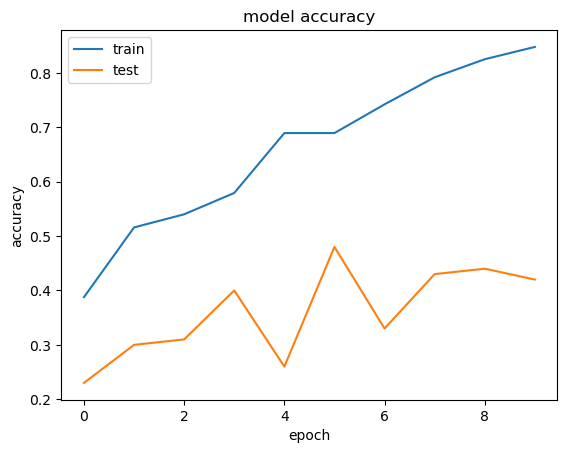

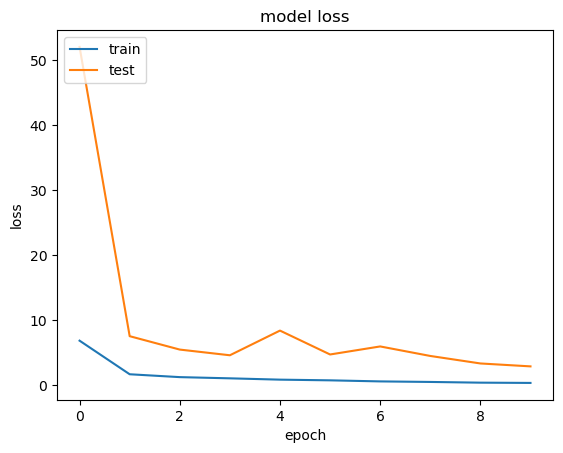

In [18]:
plot_loss_accuracy(history_model1)

### Trial #2

Conv2D + TimeDristributed + GRU

In [19]:
input_shape = (20, 120, 120, 3)

model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam()#lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 118, 118, 32   896       
 ributed)                    )                                   
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 59, 59, 32)    0         
 stributed)                                                      
                                                                 
 batch_normalization_3 (Bat  (None, 20, 59, 59, 32)    128       
 chNormalization)                                                
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 57, 57, 64)    18496     
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 28, 28, 64)   

In [20]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/vl/vtj4wvk929l5x6hncfgprdyr0000gn/T/ipykernel_32324/3383535347.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/10

Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-2.67369-0.12500.h5
 1/42 [..............................] - ETA: 2:05 - loss: 2.6737 - categorical_accuracy: 0.1250
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-2.30522-0.12500.h5
 2/42 [>.............................] - ETA: 1:52 - loss: 2.3052 - categorical_accuracy: 0.1250
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-2.09670-0.18750.h5
 3/42 [=>............................] - ETA: 1:41 - loss: 2.0967 - categorical_accuracy: 0.1875
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-1.92265-0.25000.h5
 4/42 [=>............................] - ETA: 1:37 - loss: 1.9227 - categorical_accuracy: 0.2500
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-1.82485-0.27500.h5
 5/42 [==>...........................] - ETA: 1:37 - loss: 1.8249 - categorical_accuracy: 0.2750
Epoch 1: saving model to model_init_20

 1/42 [..............................] - ETA: 1:10 - loss: 1.2035 - categorical_accuracy: 0.5625
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-1.05468-0.65625.h5
 2/42 [>.............................] - ETA: 1:03 - loss: 1.0547 - categorical_accuracy: 0.6562
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-1.12112-0.56250.h5
 3/42 [=>............................] - ETA: 1:03 - loss: 1.1211 - categorical_accuracy: 0.5625
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-1.17906-0.54688.h5
 4/42 [=>............................] - ETA: 1:04 - loss: 1.1791 - categorical_accuracy: 0.5469
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-1.17116-0.53750.h5
 5/42 [==>...........................] - ETA: 1:04 - loss: 1.1712 - categorical_accuracy: 0.5375
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-1.14024-0.52083.h5
 6/42 [===>..........................] - ETA: 1:02

 2/42 [>.............................] - ETA: 1:16 - loss: 0.8708 - categorical_accuracy: 0.6875
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-0.85645-0.62500.h5
 3/42 [=>............................] - ETA: 1:13 - loss: 0.8564 - categorical_accuracy: 0.6250
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-0.95446-0.56250.h5
 4/42 [=>............................] - ETA: 1:09 - loss: 0.9545 - categorical_accuracy: 0.5625
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-0.89334-0.62500.h5
 5/42 [==>...........................] - ETA: 1:08 - loss: 0.8933 - categorical_accuracy: 0.6250
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-0.86889-0.65625.h5
 6/42 [===>..........................] - ETA: 1:07 - loss: 0.8689 - categorical_accuracy: 0.6562
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-0.87696-0.65179.h5
 7/42 [====>.........................] - ETA: 1:04

 3/42 [=>............................] - ETA: 1:04 - loss: 0.8132 - categorical_accuracy: 0.6458
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.79624-0.62500.h5
 4/42 [=>............................] - ETA: 1:02 - loss: 0.7962 - categorical_accuracy: 0.6250
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.76237-0.62500.h5
 5/42 [==>...........................] - ETA: 1:00 - loss: 0.7624 - categorical_accuracy: 0.6250
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.76508-0.64583.h5
 6/42 [===>..........................] - ETA: 57s - loss: 0.7651 - categorical_accuracy: 0.6458 
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.78561-0.65179.h5
 7/42 [====>.........................] - ETA: 54s - loss: 0.7856 - categorical_accuracy: 0.6518
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.78205-0.67188.h5
 8/42 [====>.........................] - ETA: 52s -

 4/42 [=>............................] - ETA: 1:09 - loss: 0.6444 - categorical_accuracy: 0.7500
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.65118-0.73750.h5
 5/42 [==>...........................] - ETA: 1:10 - loss: 0.6512 - categorical_accuracy: 0.7375
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.64557-0.73958.h5
 6/42 [===>..........................] - ETA: 1:07 - loss: 0.6456 - categorical_accuracy: 0.7396
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.62030-0.75000.h5
 7/42 [====>.........................] - ETA: 1:05 - loss: 0.6203 - categorical_accuracy: 0.7500
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.66505-0.72656.h5
 8/42 [====>.........................] - ETA: 1:02 - loss: 0.6650 - categorical_accuracy: 0.7266
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.68073-0.70833.h5
 9/42 [=====>........................] - ETA: 59s 

 4/42 [=>............................] - ETA: 1:26 - loss: 1.1092 - categorical_accuracy: 0.5312
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-1.00508-0.58750.h5
 5/42 [==>...........................] - ETA: 1:22 - loss: 1.0051 - categorical_accuracy: 0.5875
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.93597-0.61458.h5
 6/42 [===>..........................] - ETA: 1:18 - loss: 0.9360 - categorical_accuracy: 0.6146
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.92469-0.61607.h5
 7/42 [====>.........................] - ETA: 1:16 - loss: 0.9247 - categorical_accuracy: 0.6161
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.90420-0.62500.h5
 8/42 [====>.........................] - ETA: 1:13 - loss: 0.9042 - categorical_accuracy: 0.6250
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.89144-0.63194.h5
 9/42 [=====>........................] - ETA: 1:10

 5/42 [==>...........................] - ETA: 1:04 - loss: 0.5533 - categorical_accuracy: 0.7750
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.52284-0.80208.h5
 6/42 [===>..........................] - ETA: 1:01 - loss: 0.5228 - categorical_accuracy: 0.8021
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.57259-0.76786.h5
 7/42 [====>.........................] - ETA: 59s - loss: 0.5726 - categorical_accuracy: 0.7679 
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.55843-0.78125.h5
 8/42 [====>.........................] - ETA: 57s - loss: 0.5584 - categorical_accuracy: 0.7812
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.56221-0.78472.h5
 9/42 [=====>........................] - ETA: 56s - loss: 0.5622 - categorical_accuracy: 0.7847
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.56033-0.78125.h5
10/42 [======>.......................] - ETA: 54s - 

 6/42 [===>..........................] - ETA: 58s - loss: 0.5588 - categorical_accuracy: 0.8229 
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.61021-0.79464.h5
 7/42 [====>.........................] - ETA: 56s - loss: 0.6102 - categorical_accuracy: 0.7946
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.59262-0.80469.h5
 8/42 [====>.........................] - ETA: 54s - loss: 0.5926 - categorical_accuracy: 0.8047
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.57666-0.80556.h5
 9/42 [=====>........................] - ETA: 52s - loss: 0.5767 - categorical_accuracy: 0.8056
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.57760-0.80000.h5
10/42 [======>.......................] - ETA: 51s - loss: 0.5776 - categorical_accuracy: 0.8000
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.56983-0.80114.h5
11/42 [======>.......................] - ETA: 50s - lo

 6/42 [===>..........................] - ETA: 1:24 - loss: 0.5285 - categorical_accuracy: 0.7812
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.54945-0.76786.h5
 7/42 [====>.........................] - ETA: 1:19 - loss: 0.5494 - categorical_accuracy: 0.7679
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.54871-0.78125.h5
 8/42 [====>.........................] - ETA: 1:17 - loss: 0.5487 - categorical_accuracy: 0.7812
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.52284-0.79861.h5
 9/42 [=====>........................] - ETA: 1:13 - loss: 0.5228 - categorical_accuracy: 0.7986
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.52681-0.80000.h5
10/42 [======>.......................] - ETA: 1:10 - loss: 0.5268 - categorical_accuracy: 0.8000
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.51519-0.80682.h5
11/42 [======>.......................] - ETA: 1:06

 7/42 [====>.........................] - ETA: 57s - loss: 0.5283 - categorical_accuracy: 0.7946
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.51274-0.78906.h5
 8/42 [====>.........................] - ETA: 55s - loss: 0.5127 - categorical_accuracy: 0.7891
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.50334-0.79861.h5
 9/42 [=====>........................] - ETA: 53s - loss: 0.5033 - categorical_accuracy: 0.7986
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.48751-0.80000.h5
10/42 [======>.......................] - ETA: 51s - loss: 0.4875 - categorical_accuracy: 0.8000
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.53071-0.77841.h5
11/42 [======>.......................] - ETA: 50s - loss: 0.5307 - categorical_accuracy: 0.7784
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.53393-0.78125.h5
12/42 [=======>......................] - ETA: 48s 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


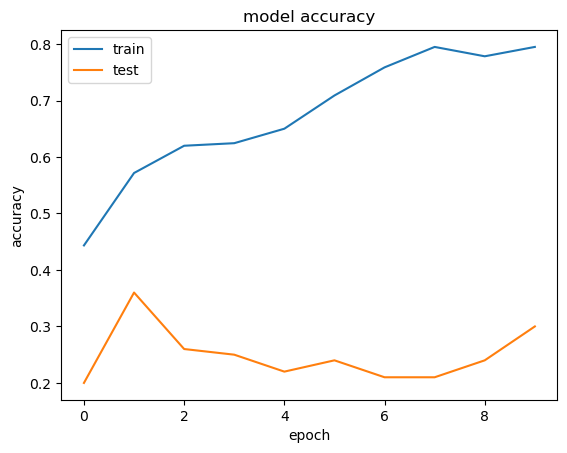

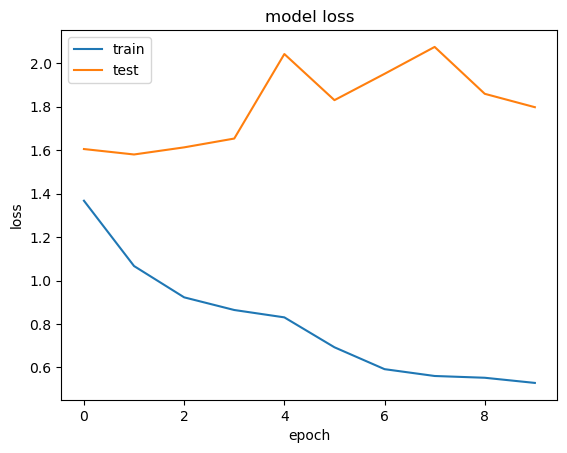

In [21]:
plot_loss_accuracy(history)

### Trial #3

Conv2D + TimeDistributed + GlobalAveragePooling2D

In [22]:
model = Sequential()

model.add(TimeDistributed(Conv2D(8, (3,3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
model.add(BatchNormalization())

model.add(ConvLSTM2D(8, kernel_size = 3, return_sequences=False))
model.add(BatchNormalization())

model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

optimiser = optimizers.Adam()#lr=0.01) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDi  (None, 20, 118, 118, 8)   224       
 stributed)                                                      
                                                                 
 batch_normalization_7 (Bat  (None, 20, 118, 118, 8)   32        
 chNormalization)                                                
                                                                 
 time_distributed_7 (TimeDi  (None, 20, 116, 116, 16   1168      
 stributed)                  )                                   
                                                                 
 batch_normalization_8 (Bat  (None, 20, 116, 116, 16   64        
 chNormalization)            )                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 114, 114, 8)      

In [23]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/vl/vtj4wvk929l5x6hncfgprdyr0000gn/T/ipykernel_32324/3383535347.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/10

Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-1.63765-0.12500.h5
 1/42 [..............................] - ETA: 4:20 - loss: 1.6376 - categorical_accuracy: 0.1250
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-1.65786-0.09375.h5
 2/42 [>.............................] - ETA: 3:25 - loss: 1.6579 - categorical_accuracy: 0.0938
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-1.65043-0.10417.h5
 3/42 [=>............................] - ETA: 3:13 - loss: 1.6504 - categorical_accuracy: 0.1042
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-1.62687-0.17188.h5
 4/42 [=>............................] - ETA: 3:07 - loss: 1.6269 - categorical_accuracy: 0.1719
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-1.60187-0.23750.h5
 5/42 [==>...........................] - ETA: 3:01 - loss: 1.6019 - categorical_accuracy: 0.2375
Epoch 1: saving model to model_init_20

 1/42 [..............................] - ETA: 3:08 - loss: 1.4761 - categorical_accuracy: 0.4375
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-1.34481-0.43750.h5
 2/42 [>.............................] - ETA: 3:03 - loss: 1.3448 - categorical_accuracy: 0.4375
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-1.34544-0.39583.h5
 3/42 [=>............................] - ETA: 2:57 - loss: 1.3454 - categorical_accuracy: 0.3958
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-1.39649-0.34375.h5
 4/42 [=>............................] - ETA: 2:50 - loss: 1.3965 - categorical_accuracy: 0.3438
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-1.36732-0.38750.h5
 5/42 [==>...........................] - ETA: 2:43 - loss: 1.3673 - categorical_accuracy: 0.3875
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-1.37250-0.37500.h5
 6/42 [===>..........................] - ETA: 2:37

 2/42 [>.............................] - ETA: 3:40 - loss: 1.0175 - categorical_accuracy: 0.5938
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-1.04764-0.62500.h5
 3/42 [=>............................] - ETA: 3:36 - loss: 1.0476 - categorical_accuracy: 0.6250
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-1.01739-0.64062.h5
 4/42 [=>............................] - ETA: 3:36 - loss: 1.0174 - categorical_accuracy: 0.6406
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-1.02594-0.62500.h5
 5/42 [==>...........................] - ETA: 3:22 - loss: 1.0259 - categorical_accuracy: 0.6250
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-1.00965-0.63542.h5
 6/42 [===>..........................] - ETA: 3:12 - loss: 1.0096 - categorical_accuracy: 0.6354
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-1.00608-0.62500.h5
 7/42 [====>.........................] - ETA: 3:04

 3/42 [=>............................] - ETA: 3:18 - loss: 0.9712 - categorical_accuracy: 0.5417
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.96285-0.56250.h5
 4/42 [=>............................] - ETA: 3:16 - loss: 0.9628 - categorical_accuracy: 0.5625
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.97631-0.53750.h5
 5/42 [==>...........................] - ETA: 3:09 - loss: 0.9763 - categorical_accuracy: 0.5375
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-1.01153-0.54167.h5
 6/42 [===>..........................] - ETA: 3:04 - loss: 1.0115 - categorical_accuracy: 0.5417
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.99876-0.55357.h5
 7/42 [====>.........................] - ETA: 3:00 - loss: 0.9988 - categorical_accuracy: 0.5536
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-1.00284-0.55469.h5
 8/42 [====>.........................] - ETA: 2:54

 3/42 [=>............................] - ETA: 3:19 - loss: 0.9827 - categorical_accuracy: 0.6042
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-1.01457-0.57812.h5
 4/42 [=>............................] - ETA: 3:17 - loss: 1.0146 - categorical_accuracy: 0.5781
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.96774-0.60000.h5
 5/42 [==>...........................] - ETA: 3:12 - loss: 0.9677 - categorical_accuracy: 0.6000
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.93706-0.60417.h5
 6/42 [===>..........................] - ETA: 3:07 - loss: 0.9371 - categorical_accuracy: 0.6042
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.97258-0.58036.h5
 7/42 [====>.........................] - ETA: 3:00 - loss: 0.9726 - categorical_accuracy: 0.5804
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.96655-0.57812.h5
 8/42 [====>.........................] - ETA: 2:54

 4/42 [=>............................] - ETA: 3:09 - loss: 0.8604 - categorical_accuracy: 0.6719
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.87893-0.67500.h5
 5/42 [==>...........................] - ETA: 3:04 - loss: 0.8789 - categorical_accuracy: 0.6750
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.87034-0.68750.h5
 6/42 [===>..........................] - ETA: 2:56 - loss: 0.8703 - categorical_accuracy: 0.6875
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.86186-0.69643.h5
 7/42 [====>.........................] - ETA: 2:51 - loss: 0.8619 - categorical_accuracy: 0.6964
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.86121-0.67969.h5
 8/42 [====>.........................] - ETA: 2:46 - loss: 0.8612 - categorical_accuracy: 0.6797
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.83704-0.68056.h5
 9/42 [=====>........................] - ETA: 2:40

 5/42 [==>...........................] - ETA: 3:11 - loss: 0.7629 - categorical_accuracy: 0.7125
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.77058-0.70833.h5
 6/42 [===>..........................] - ETA: 3:07 - loss: 0.7706 - categorical_accuracy: 0.7083
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.74371-0.74107.h5
 7/42 [====>.........................] - ETA: 3:04 - loss: 0.7437 - categorical_accuracy: 0.7411
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.74321-0.75000.h5
 8/42 [====>.........................] - ETA: 3:01 - loss: 0.7432 - categorical_accuracy: 0.7500
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.75838-0.72917.h5
 9/42 [=====>........................] - ETA: 2:57 - loss: 0.7584 - categorical_accuracy: 0.7292
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.77616-0.70625.h5
10/42 [======>.......................] - ETA: 2:52

 5/42 [==>...........................] - ETA: 2:46 - loss: 0.8252 - categorical_accuracy: 0.6250
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.77586-0.67708.h5
 6/42 [===>..........................] - ETA: 2:44 - loss: 0.7759 - categorical_accuracy: 0.6771
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.78758-0.66964.h5
 7/42 [====>.........................] - ETA: 2:41 - loss: 0.7876 - categorical_accuracy: 0.6696
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.77946-0.67969.h5
 8/42 [====>.........................] - ETA: 2:36 - loss: 0.7795 - categorical_accuracy: 0.6797
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.83533-0.65278.h5
 9/42 [=====>........................] - ETA: 2:33 - loss: 0.8353 - categorical_accuracy: 0.6528
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.82182-0.65625.h5
10/42 [======>.......................] - ETA: 2:28

 6/42 [===>..........................] - ETA: 3:00 - loss: 0.9302 - categorical_accuracy: 0.6354
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.91162-0.65179.h5
 7/42 [====>.........................] - ETA: 2:54 - loss: 0.9116 - categorical_accuracy: 0.6518
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.88970-0.67188.h5
 8/42 [====>.........................] - ETA: 2:49 - loss: 0.8897 - categorical_accuracy: 0.6719
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.87112-0.67361.h5
 9/42 [=====>........................] - ETA: 2:44 - loss: 0.8711 - categorical_accuracy: 0.6736
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.85344-0.67500.h5
10/42 [======>.......................] - ETA: 2:38 - loss: 0.8534 - categorical_accuracy: 0.6750
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.85905-0.66477.h5
11/42 [======>.......................] - ETA: 2:33

 7/42 [====>.........................] - ETA: 2:57 - loss: 0.7808 - categorical_accuracy: 0.7143
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.77357-0.72656.h5
 8/42 [====>.........................] - ETA: 2:51 - loss: 0.7736 - categorical_accuracy: 0.7266
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.76382-0.73611.h5
 9/42 [=====>........................] - ETA: 2:45 - loss: 0.7638 - categorical_accuracy: 0.7361
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.78430-0.71250.h5
10/42 [======>.......................] - ETA: 2:39 - loss: 0.7843 - categorical_accuracy: 0.7125
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.78625-0.71591.h5
11/42 [======>.......................] - ETA: 2:34 - loss: 0.7862 - categorical_accuracy: 0.7159
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.80321-0.71354.h5
12/42 [=======>......................] - ETA:

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


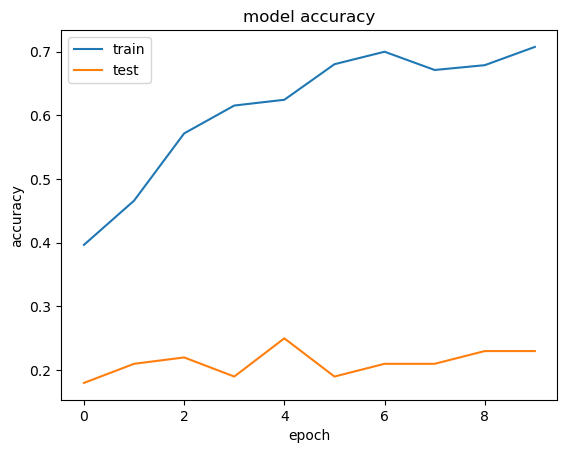

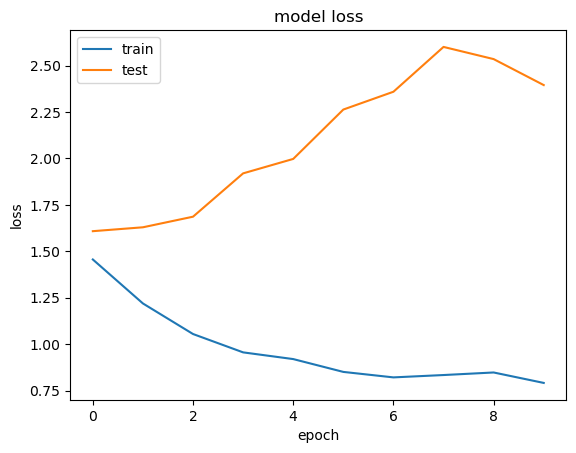

In [24]:
plot_loss_accuracy(history)

### Trial #4:

Conv3D + LSTM

In [25]:
from keras.layers import ConvLSTM3D, Bidirectional, LSTM, Reshape
from keras.models import Sequential

In [26]:
input_shape = (20, 120, 120, 3)

model = Sequential()

model.add(Conv3D(32, (3, 3, 3), input_shape=input_shape, activation='relu', padding='valid'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(64, (3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(128, (3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2), padding='same'))
model.add(BatchNormalization())

shape = model.layers[-1].output_shape
model.add(Reshape((shape[-1],shape[1]*shape[2]*shape[3])))

model.add(LSTM(32, return_sequences=True))
model.add(Dropout(.5))

model.add((Flatten()))

model.add(Dense(512, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(5, activation='softmax'))

In [27]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 18, 118, 118, 32   2624      
                             )                                   
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 9, 59, 59, 32)     0         
 g3D)                                                            
                                                                 
 batch_normalization_11 (Ba  (None, 9, 59, 59, 32)     128       
 tchNormalization)                                               
                                                                 
 conv3d_4 (Conv3D)           (None, 7, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 3, 28, 28, 64)     0         
 g3D)                                                 

In [28]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/vl/vtj4wvk929l5x6hncfgprdyr0000gn/T/ipykernel_32324/3383535347.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/10

Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-1.73696-0.25000.h5
 1/42 [..............................] - ETA: 4:12 - loss: 1.7370 - categorical_accuracy: 0.2500
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-1.73863-0.25000.h5
 2/42 [>.............................] - ETA: 3:34 - loss: 1.7386 - categorical_accuracy: 0.2500
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-1.76605-0.22917.h5
 3/42 [=>............................] - ETA: 3:22 - loss: 1.7661 - categorical_accuracy: 0.2292
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-1.77724-0.20312.h5
 4/42 [=>............................] - ETA: 3:15 - loss: 1.7772 - categorical_accuracy: 0.2031
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-1.77495-0.21250.h5
 5/42 [==>...........................] - ETA: 3:09 - loss: 1.7750 - categorical_accuracy: 0.2125
Epoch 1: saving model to model_init_20

 1/42 [..............................] - ETA: 3:30 - loss: 1.1358 - categorical_accuracy: 0.4375
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-1.09572-0.50000.h5
 2/42 [>.............................] - ETA: 3:40 - loss: 1.0957 - categorical_accuracy: 0.5000
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-1.05503-0.58333.h5
 3/42 [=>............................] - ETA: 3:45 - loss: 1.0550 - categorical_accuracy: 0.5833
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-1.14981-0.53125.h5
 4/42 [=>............................] - ETA: 3:30 - loss: 1.1498 - categorical_accuracy: 0.5312
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-1.15514-0.53750.h5
 5/42 [==>...........................] - ETA: 3:21 - loss: 1.1551 - categorical_accuracy: 0.5375
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-1.12872-0.54167.h5
 6/42 [===>..........................] - ETA: 3:15

 2/42 [>.............................] - ETA: 3:34 - loss: 0.7651 - categorical_accuracy: 0.7500
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-0.82558-0.75000.h5
 3/42 [=>............................] - ETA: 3:29 - loss: 0.8256 - categorical_accuracy: 0.7500
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-0.79284-0.75000.h5
 4/42 [=>............................] - ETA: 3:27 - loss: 0.7928 - categorical_accuracy: 0.7500
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-0.76245-0.76250.h5
 5/42 [==>...........................] - ETA: 3:21 - loss: 0.7624 - categorical_accuracy: 0.7625
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-0.79815-0.70833.h5
 6/42 [===>..........................] - ETA: 3:15 - loss: 0.7981 - categorical_accuracy: 0.7083
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-0.84765-0.66964.h5
 7/42 [====>.........................] - ETA: 3:09

 3/42 [=>............................] - ETA: 3:21 - loss: 0.5507 - categorical_accuracy: 0.7708
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.57928-0.76562.h5
 4/42 [=>............................] - ETA: 3:15 - loss: 0.5793 - categorical_accuracy: 0.7656
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.55159-0.78750.h5
 5/42 [==>...........................] - ETA: 3:09 - loss: 0.5516 - categorical_accuracy: 0.7875
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.59601-0.77083.h5
 6/42 [===>..........................] - ETA: 3:04 - loss: 0.5960 - categorical_accuracy: 0.7708
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.61228-0.75000.h5
 7/42 [====>.........................] - ETA: 2:59 - loss: 0.6123 - categorical_accuracy: 0.7500
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.61050-0.74219.h5
 8/42 [====>.........................] - ETA: 2:53

 4/42 [=>............................] - ETA: 3:18 - loss: 0.4020 - categorical_accuracy: 0.8750
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.43117-0.85000.h5
 5/42 [==>...........................] - ETA: 3:14 - loss: 0.4312 - categorical_accuracy: 0.8500
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.45814-0.83333.h5
 6/42 [===>..........................] - ETA: 3:08 - loss: 0.4581 - categorical_accuracy: 0.8333
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.45521-0.83036.h5
 7/42 [====>.........................] - ETA: 3:01 - loss: 0.4552 - categorical_accuracy: 0.8304
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.48365-0.82812.h5
 8/42 [====>.........................] - ETA: 2:56 - loss: 0.4837 - categorical_accuracy: 0.8281
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.50705-0.81944.h5
 9/42 [=====>........................] - ETA: 2:50

 5/42 [==>...........................] - ETA: 3:15 - loss: 0.4782 - categorical_accuracy: 0.8375
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.45168-0.84375.h5
 6/42 [===>..........................] - ETA: 3:08 - loss: 0.4517 - categorical_accuracy: 0.8438
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.46637-0.83929.h5
 7/42 [====>.........................] - ETA: 3:02 - loss: 0.4664 - categorical_accuracy: 0.8393
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.49786-0.82812.h5
 8/42 [====>.........................] - ETA: 2:56 - loss: 0.4979 - categorical_accuracy: 0.8281
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.49578-0.82639.h5
 9/42 [=====>........................] - ETA: 2:50 - loss: 0.4958 - categorical_accuracy: 0.8264
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.48895-0.82500.h5
10/42 [======>.......................] - ETA: 2:45

 6/42 [===>..........................] - ETA: 3:13 - loss: 0.2714 - categorical_accuracy: 0.9062
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.31773-0.88393.h5
 7/42 [====>.........................] - ETA: 3:07 - loss: 0.3177 - categorical_accuracy: 0.8839
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.31990-0.89062.h5
 8/42 [====>.........................] - ETA: 3:01 - loss: 0.3199 - categorical_accuracy: 0.8906
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.32332-0.89583.h5
 9/42 [=====>........................] - ETA: 2:55 - loss: 0.3233 - categorical_accuracy: 0.8958
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.32924-0.88750.h5
10/42 [======>.......................] - ETA: 2:49 - loss: 0.3292 - categorical_accuracy: 0.8875
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.35047-0.88068.h5
11/42 [======>.......................] - ETA: 2:44

 6/42 [===>..........................] - ETA: 3:06 - loss: 0.2750 - categorical_accuracy: 0.8958
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.25055-0.91071.h5
 7/42 [====>.........................] - ETA: 3:01 - loss: 0.2505 - categorical_accuracy: 0.9107
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.30912-0.90625.h5
 8/42 [====>.........................] - ETA: 2:55 - loss: 0.3091 - categorical_accuracy: 0.9062
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.29791-0.90972.h5
 9/42 [=====>........................] - ETA: 2:49 - loss: 0.2979 - categorical_accuracy: 0.9097
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.28480-0.91250.h5
10/42 [======>.......................] - ETA: 2:44 - loss: 0.2848 - categorical_accuracy: 0.9125
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.27432-0.91477.h5
11/42 [======>.......................] - ETA: 2:39

 7/42 [====>.........................] - ETA: 3:01 - loss: 0.1169 - categorical_accuracy: 0.9732
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.14930-0.96094.h5
 8/42 [====>.........................] - ETA: 2:55 - loss: 0.1493 - categorical_accuracy: 0.9609
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.15797-0.95139.h5
 9/42 [=====>........................] - ETA: 2:49 - loss: 0.1580 - categorical_accuracy: 0.9514
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.14646-0.95625.h5
10/42 [======>.......................] - ETA: 2:44 - loss: 0.1465 - categorical_accuracy: 0.9563
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.13832-0.96023.h5
11/42 [======>.......................] - ETA: 2:39 - loss: 0.1383 - categorical_accuracy: 0.9602
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.13845-0.95833.h5
12/42 [=======>......................] - ETA: 2:33

 8/42 [====>.........................] - ETA: 2:54 - loss: 0.1296 - categorical_accuracy: 0.9531
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.12483-0.95833.h5
 9/42 [=====>........................] - ETA: 2:49 - loss: 0.1248 - categorical_accuracy: 0.9583
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.12188-0.96250.h5
10/42 [======>.......................] - ETA: 2:44 - loss: 0.1219 - categorical_accuracy: 0.9625
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.13601-0.95455.h5
11/42 [======>.......................] - ETA: 2:40 - loss: 0.1360 - categorical_accuracy: 0.9545
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.13497-0.95833.h5
12/42 [=======>......................] - ETA: 2:35 - loss: 0.1350 - categorical_accuracy: 0.9583
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.14350-0.95673.h5
13/42 [========>.....................] - ETA:

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


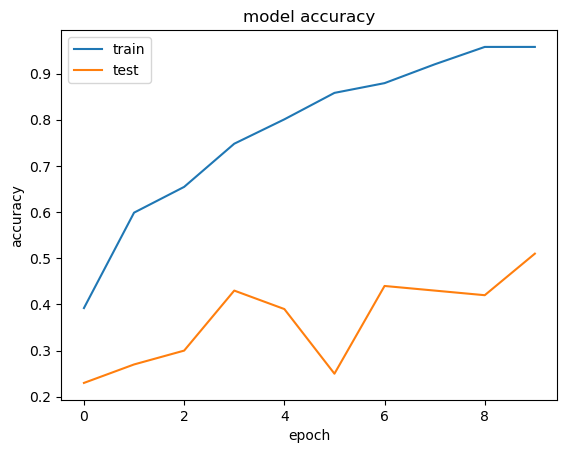

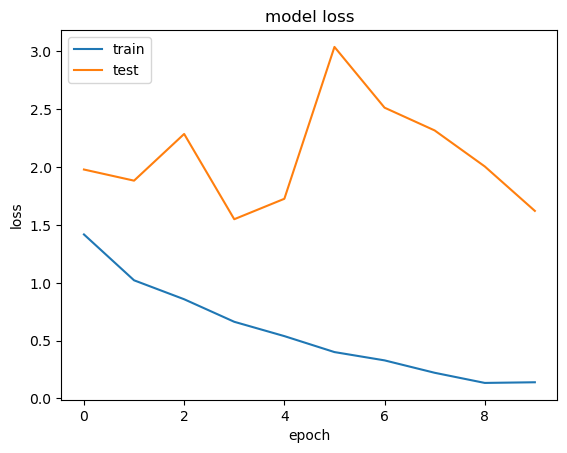

In [29]:
plot_loss_accuracy(history)

### Trial #5

Conv3D 4 layers, Dense 2 layers with 256 and 128 and 25% dropout

In [30]:
model = Sequential()

model.add(Conv3D(8, (3, 3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(16, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
 
model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
model.add(Conv3D(64, (3, 3, 3), padding='same'))    
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5))
model.add(Activation('softmax'))

In [31]:
optimiser = optimizers.Adam()
model.compile(optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 20, 120, 120, 8)   656       
                                                                 
 activation_1 (Activation)   (None, 20, 120, 120, 8)   0         
                                                                 
 batch_normalization_14 (Ba  (None, 20, 120, 120, 8)   32        
 tchNormalization)                                               
                                                                 
 max_pooling3d_6 (MaxPoolin  (None, 10, 60, 60, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_7 (Conv3D)           (None, 10, 60, 60, 16)    3472      
                                                                 
 activation_2 (Activation)   (None, 10, 60, 60, 16)   

In [32]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [33]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/vl/vtj4wvk929l5x6hncfgprdyr0000gn/T/ipykernel_32324/2794917941.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/10

Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-2.07693-0.25000.h5
 1/42 [..............................] - ETA: 2:11 - loss: 2.0769 - categorical_accuracy: 0.2500
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-2.20812-0.18750.h5
 2/42 [>.............................] - ETA: 1:42 - loss: 2.2081 - categorical_accuracy: 0.1875
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-2.12186-0.22917.h5
 3/42 [=>............................] - ETA: 1:37 - loss: 2.1219 - categorical_accuracy: 0.2292
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-1.93555-0.29688.h5
 4/42 [=>............................] - ETA: 1:35 - loss: 1.9355 - categorical_accuracy: 0.2969
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-1.80409-0.32500.h5
 5/42 [==>...........................] - ETA: 1:32 - loss: 1.8041 - categorical_accuracy: 0.3250
Epoch 1: saving model to model_init_20

 1/42 [..............................] - ETA: 1:40 - loss: 0.9539 - categorical_accuracy: 0.5625
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-1.22001-0.46875.h5
 2/42 [>.............................] - ETA: 1:37 - loss: 1.2200 - categorical_accuracy: 0.4688
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-1.02992-0.54167.h5
 3/42 [=>............................] - ETA: 1:35 - loss: 1.0299 - categorical_accuracy: 0.5417
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-1.08347-0.53125.h5
 4/42 [=>............................] - ETA: 1:33 - loss: 1.0835 - categorical_accuracy: 0.5312
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-1.05225-0.56250.h5
 5/42 [==>...........................] - ETA: 1:30 - loss: 1.0523 - categorical_accuracy: 0.5625
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-1.13411-0.55208.h5
 6/42 [===>..........................] - ETA: 1:27

 2/42 [>.............................] - ETA: 1:40 - loss: 0.6464 - categorical_accuracy: 0.7188
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-0.65574-0.72917.h5
 3/42 [=>............................] - ETA: 1:37 - loss: 0.6557 - categorical_accuracy: 0.7292
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-0.63935-0.71875.h5
 4/42 [=>............................] - ETA: 1:34 - loss: 0.6394 - categorical_accuracy: 0.7188
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-0.67020-0.72500.h5
 5/42 [==>...........................] - ETA: 1:32 - loss: 0.6702 - categorical_accuracy: 0.7250
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-0.73333-0.72917.h5
 6/42 [===>..........................] - ETA: 1:29 - loss: 0.7333 - categorical_accuracy: 0.7292
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-0.78759-0.70536.h5
 7/42 [====>.........................] - ETA: 1:27

 3/42 [=>............................] - ETA: 1:35 - loss: 1.0205 - categorical_accuracy: 0.6875
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.93022-0.68750.h5
 4/42 [=>............................] - ETA: 1:32 - loss: 0.9302 - categorical_accuracy: 0.6875
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.83263-0.72500.h5
 5/42 [==>...........................] - ETA: 1:29 - loss: 0.8326 - categorical_accuracy: 0.7250
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.90427-0.67708.h5
 6/42 [===>..........................] - ETA: 1:27 - loss: 0.9043 - categorical_accuracy: 0.6771
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.89603-0.67857.h5
 7/42 [====>.........................] - ETA: 1:25 - loss: 0.8960 - categorical_accuracy: 0.6786
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.81936-0.70312.h5
 8/42 [====>.........................] - ETA: 1:22

 3/42 [=>............................] - ETA: 1:35 - loss: 0.7661 - categorical_accuracy: 0.7917
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.66172-0.81250.h5
 4/42 [=>............................] - ETA: 1:32 - loss: 0.6617 - categorical_accuracy: 0.8125
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.70590-0.75000.h5
 5/42 [==>...........................] - ETA: 1:30 - loss: 0.7059 - categorical_accuracy: 0.7500
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.65078-0.77083.h5
 6/42 [===>..........................] - ETA: 1:27 - loss: 0.6508 - categorical_accuracy: 0.7708
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.61648-0.77679.h5
 7/42 [====>.........................] - ETA: 1:25 - loss: 0.6165 - categorical_accuracy: 0.7768
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.58960-0.78125.h5
 8/42 [====>.........................] - ETA: 1:22

 4/42 [=>............................] - ETA: 1:32 - loss: 0.5088 - categorical_accuracy: 0.7500
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.48329-0.77500.h5
 5/42 [==>...........................] - ETA: 1:30 - loss: 0.4833 - categorical_accuracy: 0.7750
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.50797-0.76042.h5
 6/42 [===>..........................] - ETA: 1:27 - loss: 0.5080 - categorical_accuracy: 0.7604
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.48445-0.77679.h5
 7/42 [====>.........................] - ETA: 1:25 - loss: 0.4844 - categorical_accuracy: 0.7768
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.48809-0.77344.h5
 8/42 [====>.........................] - ETA: 1:23 - loss: 0.4881 - categorical_accuracy: 0.7734
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.49835-0.77083.h5
 9/42 [=====>........................] - ETA: 1:20

 5/42 [==>...........................] - ETA: 1:46 - loss: 0.3490 - categorical_accuracy: 0.8750
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.36316-0.86458.h5
 6/42 [===>..........................] - ETA: 1:41 - loss: 0.3632 - categorical_accuracy: 0.8646
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.35584-0.85714.h5
 7/42 [====>.........................] - ETA: 1:36 - loss: 0.3558 - categorical_accuracy: 0.8571
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.33252-0.86719.h5
 8/42 [====>.........................] - ETA: 1:32 - loss: 0.3325 - categorical_accuracy: 0.8672
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.31727-0.86806.h5
 9/42 [=====>........................] - ETA: 1:29 - loss: 0.3173 - categorical_accuracy: 0.8681
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.31593-0.86875.h5
10/42 [======>.......................] - ETA: 1:25

 5/42 [==>...........................] - ETA: 1:31 - loss: 0.2145 - categorical_accuracy: 0.9500
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.22193-0.93750.h5
 6/42 [===>..........................] - ETA: 1:29 - loss: 0.2219 - categorical_accuracy: 0.9375
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.23395-0.92857.h5
 7/42 [====>.........................] - ETA: 1:26 - loss: 0.2339 - categorical_accuracy: 0.9286
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.22728-0.93750.h5
 8/42 [====>.........................] - ETA: 1:24 - loss: 0.2273 - categorical_accuracy: 0.9375
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.29281-0.90972.h5
 9/42 [=====>........................] - ETA: 1:21 - loss: 0.2928 - categorical_accuracy: 0.9097
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.30133-0.89375.h5
10/42 [======>.......................] - ETA: 1:19

 6/42 [===>..........................] - ETA: 1:29 - loss: 0.3228 - categorical_accuracy: 0.9062
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.30967-0.91071.h5
 7/42 [====>.........................] - ETA: 1:27 - loss: 0.3097 - categorical_accuracy: 0.9107
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.32696-0.89844.h5
 8/42 [====>.........................] - ETA: 1:24 - loss: 0.3270 - categorical_accuracy: 0.8984
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.30703-0.90972.h5
 9/42 [=====>........................] - ETA: 1:22 - loss: 0.3070 - categorical_accuracy: 0.9097
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.29789-0.91250.h5
10/42 [======>.......................] - ETA: 1:19 - loss: 0.2979 - categorical_accuracy: 0.9125
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.31501-0.90341.h5
11/42 [======>.......................] - ETA: 1:16

 7/42 [====>.........................] - ETA: 1:26 - loss: 0.3668 - categorical_accuracy: 0.9196
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.35597-0.91406.h5
 8/42 [====>.........................] - ETA: 1:24 - loss: 0.3560 - categorical_accuracy: 0.9141
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.33631-0.91667.h5
 9/42 [=====>........................] - ETA: 1:21 - loss: 0.3363 - categorical_accuracy: 0.9167
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.33627-0.90625.h5
10/42 [======>.......................] - ETA: 1:19 - loss: 0.3363 - categorical_accuracy: 0.9062
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.33977-0.90341.h5
11/42 [======>.......................] - ETA: 1:16 - loss: 0.3398 - categorical_accuracy: 0.9034
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.31946-0.91146.h5
12/42 [=======>......................] - ETA:

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


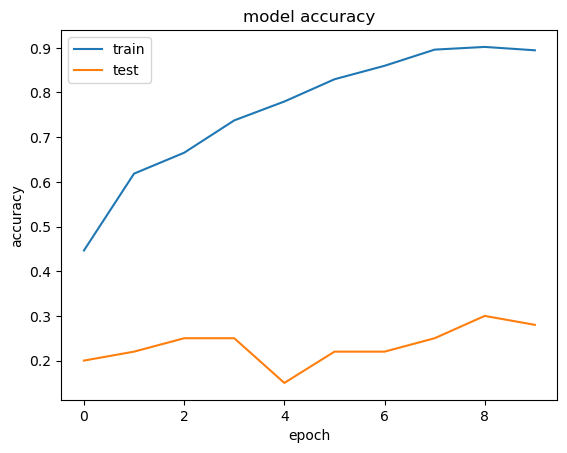

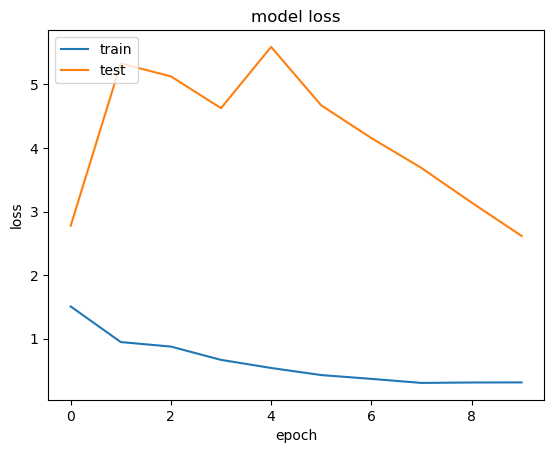

In [34]:
plot_loss_accuracy(history)

### Trial #6
Transfer Learning

In [35]:
from keras.applications import mobilenet

def mobilenet_RNN(fine_tune=False, gru=False, lstm_gru_cells=128, dense_nodes=128, dropout=0.25, num_images=20, height=120, width=120):

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))

    if (fine_tune):
        # Fine-tune from this layer onwards
        fine_tune_at = 50
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in mobilenet_transfer.layers[:fine_tune_at]:
            layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    if (gru):
        model.add(GRU(lstm_gru_cells))
    else:
        model.add(LSTM(lstm_gru_cells))
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(5, activation='softmax'))

    opt = optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    return model

In [36]:
num_epochs = 20 
print ('# epochs =', num_epochs)
batch_size = 10
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(num_images=num_frames, gru=True)
print (model.summary())

# epochs = 20
# batch size = 10
# num frames per video = 20


17225924/17225924 [==============================] - 2s 0us/step
Number of layers in the pretrained mobilenet model:  86


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDi  (None, 20, 3, 3, 1024)    3228864   
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, 20, 3, 3, 1024)    4096      
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, 20, 1, 1, 1024)    0         
 istributed)                                                     
                                                                 
 time_distributed_12 (TimeD  (None, 20, 1024)          0         
 istributed)                                                     
                                                                 
 gru_1 (GRU)                 (None, 128)              

In [37]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [38]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/var/folders/vl/vtj4wvk929l5x6hncfgprdyr0000gn/T/ipykernel_32324/2794917941.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20

Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-1.61122-0.31250.h5
 1/67 [..............................] - ETA: 9:08 - loss: 1.6112 - categorical_accuracy: 0.3125
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-1.83661-0.18750.h5
 2/67 [..............................] - ETA: 5:24 - loss: 1.8366 - categorical_accuracy: 0.1875
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-1.95960-0.18750.h5
 3/67 [>.............................] - ETA: 5:21 - loss: 1.9596 - categorical_accuracy: 0.1875
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-1.82073-0.23438.h5
 4/67 [>.............................] - ETA: 5:14 - loss: 1.8207 - categorical_accuracy: 0.2344
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-1.77076-0.23750.h5
 5/67 [=>............................] - ETA: 5:08 - loss: 1.7708 - categorical_accuracy: 0.2375
Epoch 1: saving model to model_init_20

44/67 [==================>...........] - ETA: 1:50 - loss: 1.1973 - categorical_accuracy: 0.5165
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-1.19324-0.51758.h5
45/67 [===================>..........] - ETA: 1:46 - loss: 1.1932 - categorical_accuracy: 0.5176
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-1.17477-0.52545.h5
46/67 [===================>..........] - ETA: 1:41 - loss: 1.1748 - categorical_accuracy: 0.5254
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-1.16381-0.53028.h5
47/67 [====================>.........] - ETA: 1:36 - loss: 1.1638 - categorical_accuracy: 0.5303
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-1.15951-0.53228.h5
48/67 [====================>.........] - ETA: 1:31 - loss: 1.1595 - categorical_accuracy: 0.5323
Epoch 1: saving model to model_init_2023-12-2921_29_49.539604/model-00001-1.16107-0.53161.h5
49/67 [====================>.........] - ETA: 1:27

20/67 [=======>......................] - ETA: 3:50 - loss: 0.3764 - categorical_accuracy: 0.8553
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-0.37067-0.85627.h5
21/67 [========>.....................] - ETA: 3:46 - loss: 0.3707 - categorical_accuracy: 0.8563
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-0.36549-0.86006.h5
22/67 [========>.....................] - ETA: 3:41 - loss: 0.3655 - categorical_accuracy: 0.8601
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-0.36171-0.86351.h5
23/67 [=========>....................] - ETA: 3:36 - loss: 0.3617 - categorical_accuracy: 0.8635
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-0.35843-0.86400.h5
24/67 [=========>....................] - ETA: 3:31 - loss: 0.3584 - categorical_accuracy: 0.8640
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-0.34866-0.86957.h5
25/67 [==========>...................] - ETA: 3:26

63/67 [===========================>..] - ETA: 19s - loss: 0.3157 - categorical_accuracy: 0.8879
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-0.31531-0.88867.h5
64/67 [===========================>..] - ETA: 14s - loss: 0.3153 - categorical_accuracy: 0.8887
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-0.31299-0.88943.h5
65/67 [============================>.] - ETA: 9s - loss: 0.3130 - categorical_accuracy: 0.8894 
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-0.30897-0.89114.h5
66/67 [============================>.] - ETA: 4s - loss: 0.3090 - categorical_accuracy: 0.8911
Epoch 2: saving model to model_init_2023-12-2921_29_49.539604/model-00002-0.30812-0.88994.h5
67/67 [==============================] - 339s 5s/step - loss: 0.3081 - categorical_accuracy: 0.8899 - val_loss: 0.4364 - val_categorical_accuracy: 0.8581 - lr: 0.0010
Epoch 3/20

Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/mode

39/67 [================>.............] - ETA: 2:12 - loss: 0.1804 - categorical_accuracy: 0.9382
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-0.18072-0.93819.h5
40/67 [================>.............] - ETA: 2:08 - loss: 0.1807 - categorical_accuracy: 0.9382
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-0.17779-0.93972.h5
41/67 [=================>............] - ETA: 2:03 - loss: 0.1778 - categorical_accuracy: 0.9397
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-0.18124-0.93967.h5
42/67 [=================>............] - ETA: 1:58 - loss: 0.1812 - categorical_accuracy: 0.9397
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-0.18084-0.93962.h5
43/67 [==================>...........] - ETA: 1:53 - loss: 0.1808 - categorical_accuracy: 0.9396
Epoch 3: saving model to model_init_2023-12-2921_29_49.539604/model-00003-0.17708-0.94101.h5
44/67 [==================>...........] - ETA: 1:49

15/67 [=====>........................] - ETA: 4:13 - loss: 0.1371 - categorical_accuracy: 0.9583
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.14202-0.95312.h5
16/67 [======>.......................] - ETA: 4:08 - loss: 0.1420 - categorical_accuracy: 0.9531
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.15983-0.95221.h5
17/67 [======>.......................] - ETA: 4:03 - loss: 0.1598 - categorical_accuracy: 0.9522
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.18141-0.94444.h5
18/67 [=======>......................] - ETA: 3:58 - loss: 0.1814 - categorical_accuracy: 0.9444
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.17834-0.94408.h5
19/67 [=======>......................] - ETA: 3:52 - loss: 0.1783 - categorical_accuracy: 0.9441
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.17071-0.94687.h5
20/67 [=======>......................] - ETA: 3:48

58/67 [========================>.....] - ETA: 42s - loss: 0.1455 - categorical_accuracy: 0.9532
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.14454-0.95401.h5
59/67 [=========================>....] - ETA: 38s - loss: 0.1445 - categorical_accuracy: 0.9540
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.14260-0.95478.h5
60/67 [=========================>....] - ETA: 33s - loss: 0.1426 - categorical_accuracy: 0.9548
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.14204-0.95450.h5
61/67 [==========================>...] - ETA: 28s - loss: 0.1420 - categorical_accuracy: 0.9545
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.14302-0.95422.h5
62/67 [==========================>...] - ETA: 23s - loss: 0.1430 - categorical_accuracy: 0.9542
Epoch 4: saving model to model_init_2023-12-2921_29_49.539604/model-00004-0.14109-0.95495.h5
63/67 [===========================>..] - ETA: 19s - los

34/67 [==============>...............] - ETA: 2:38 - loss: 0.1098 - categorical_accuracy: 0.9607
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.10694-0.96189.h5
35/67 [==============>...............] - ETA: 2:33 - loss: 0.1069 - categorical_accuracy: 0.9619
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.10664-0.96120.h5
36/67 [===============>..............] - ETA: 2:28 - loss: 0.1066 - categorical_accuracy: 0.9612
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.10637-0.96055.h5
37/67 [===============>..............] - ETA: 2:23 - loss: 0.1064 - categorical_accuracy: 0.9605
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.10423-0.96160.h5
38/67 [================>.............] - ETA: 2:19 - loss: 0.1042 - categorical_accuracy: 0.9616
Epoch 5: saving model to model_init_2023-12-2921_29_49.539604/model-00005-0.10202-0.96260.h5
39/67 [================>.............] - ETA: 2:14

10/67 [===>..........................] - ETA: 4:38 - loss: 0.0901 - categorical_accuracy: 0.9688
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.11411-0.96023.h5
11/67 [===>..........................] - ETA: 4:32 - loss: 0.1141 - categorical_accuracy: 0.9602
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.10874-0.96354.h5
12/67 [====>.........................] - ETA: 4:27 - loss: 0.1087 - categorical_accuracy: 0.9635
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.10784-0.96635.h5
13/67 [====>.........................] - ETA: 4:22 - loss: 0.1078 - categorical_accuracy: 0.9663
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.13085-0.95536.h5
14/67 [=====>........................] - ETA: 4:17 - loss: 0.1308 - categorical_accuracy: 0.9554
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.14295-0.95417.h5
15/67 [=====>........................] - ETA: 4:11

53/67 [======================>.......] - ETA: 1:06 - loss: 0.1717 - categorical_accuracy: 0.9511
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.16908-0.95205.h5
54/67 [=======================>......] - ETA: 1:02 - loss: 0.1691 - categorical_accuracy: 0.9520
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.16729-0.95293.h5
55/67 [=======================>......] - ETA: 57s - loss: 0.1673 - categorical_accuracy: 0.9529 
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.16803-0.95265.h5
56/67 [========================>.....] - ETA: 52s - loss: 0.1680 - categorical_accuracy: 0.9526
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.16547-0.95349.h5
57/67 [========================>.....] - ETA: 47s - loss: 0.1655 - categorical_accuracy: 0.9535
Epoch 6: saving model to model_init_2023-12-2921_29_49.539604/model-00006-0.17268-0.95212.h5
58/67 [========================>.....] - ETA: 43s - 

28/67 [===========>..................] - ETA: 3:04 - loss: 0.0608 - categorical_accuracy: 0.9818
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.05947-0.98242.h5
29/67 [===========>..................] - ETA: 2:59 - loss: 0.0595 - categorical_accuracy: 0.9824
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.05821-0.98301.h5
30/67 [============>.................] - ETA: 2:55 - loss: 0.0582 - categorical_accuracy: 0.9830
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.05786-0.98357.h5
31/67 [============>.................] - ETA: 2:50 - loss: 0.0579 - categorical_accuracy: 0.9836
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.07577-0.97614.h5
32/67 [=============>................] - ETA: 2:46 - loss: 0.0758 - categorical_accuracy: 0.9761
Epoch 7: saving model to model_init_2023-12-2921_29_49.539604/model-00007-0.08026-0.97303.h5
33/67 [=============>................] - ETA: 2:41

 4/67 [>.............................] - ETA: 5:02 - loss: 0.0080 - categorical_accuracy: 1.0000
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.02337-0.98750.h5
 5/67 [=>............................] - ETA: 5:00 - loss: 0.0234 - categorical_accuracy: 0.9875
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.03512-0.97917.h5
 6/67 [=>............................] - ETA: 4:56 - loss: 0.0351 - categorical_accuracy: 0.9792
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.03071-0.98214.h5
 7/67 [==>...........................] - ETA: 4:51 - loss: 0.0307 - categorical_accuracy: 0.9821
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.02863-0.98438.h5
 8/67 [==>...........................] - ETA: 4:51 - loss: 0.0286 - categorical_accuracy: 0.9844
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.02609-0.98611.h5
 9/67 [===>..........................] - ETA: 4:43

47/67 [====================>.........] - ETA: 1:36 - loss: 0.0424 - categorical_accuracy: 0.9865
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.04197-0.98682.h5
48/67 [====================>.........] - ETA: 1:31 - loss: 0.0420 - categorical_accuracy: 0.9868
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.04203-0.98710.h5
49/67 [====================>.........] - ETA: 1:26 - loss: 0.0420 - categorical_accuracy: 0.9871
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.04132-0.98736.h5
50/67 [=====================>........] - ETA: 1:21 - loss: 0.0413 - categorical_accuracy: 0.9874
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.04074-0.98761.h5
51/67 [=====================>........] - ETA: 1:16 - loss: 0.0407 - categorical_accuracy: 0.9876
Epoch 8: saving model to model_init_2023-12-2921_29_49.539604/model-00008-0.04007-0.98785.h5
52/67 [======================>.......] - ETA: 1:12

23/67 [=========>....................] - ETA: 3:36 - loss: 0.0275 - categorical_accuracy: 0.9946
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.02654-0.99479.h5
24/67 [=========>....................] - ETA: 3:31 - loss: 0.0265 - categorical_accuracy: 0.9948
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.02713-0.99500.h5
25/67 [==========>...................] - ETA: 3:26 - loss: 0.0271 - categorical_accuracy: 0.9950
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.02634-0.99519.h5
26/67 [==========>...................] - ETA: 3:21 - loss: 0.0263 - categorical_accuracy: 0.9952
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.02660-0.99537.h5
27/67 [===========>..................] - ETA: 3:16 - loss: 0.0266 - categorical_accuracy: 0.9954
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.02570-0.99554.h5
28/67 [===========>..................] - ETA: 3:11

66/67 [============================>.] - ETA: 4s - loss: 0.0208 - categorical_accuracy: 0.9962
Epoch 9: saving model to model_init_2023-12-2921_29_49.539604/model-00009-0.02076-0.99624.h5
67/67 [==============================] - ETA: 0s - loss: 0.0208 - categorical_accuracy: 0.9962
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0001.
67/67 [==============================] - 344s 5s/step - loss: 0.0208 - categorical_accuracy: 0.9962 - val_loss: 0.2111 - val_categorical_accuracy: 0.9324 - lr: 1.0000e-04
Epoch 10/20

Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.00628-1.00000.h5
 1/67 [..............................] - ETA: 5:40 - loss: 0.0063 - categorical_accuracy: 1.0000
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.04170-1.00000.h5
 2/67 [..............................] - ETA: 5:13 - loss: 0.0417 - categorical_accuracy: 1.0000
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.02822-1.00000

41/67 [=================>............] - ETA: 2:05 - loss: 0.0422 - categorical_accuracy: 0.9892
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.04123-0.98944.h5
42/67 [=================>............] - ETA: 2:00 - loss: 0.0412 - categorical_accuracy: 0.9894
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.04040-0.98969.h5
43/67 [==================>...........] - ETA: 1:55 - loss: 0.0404 - categorical_accuracy: 0.9897
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.03957-0.98993.h5
44/67 [==================>...........] - ETA: 1:50 - loss: 0.0396 - categorical_accuracy: 0.9899
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.03952-0.99015.h5
45/67 [===================>..........] - ETA: 1:45 - loss: 0.0395 - categorical_accuracy: 0.9902
Epoch 10: saving model to model_init_2023-12-2921_29_49.539604/model-00010-0.03873-0.99037.h5
46/67 [===================>..........] - ETA:

16/67 [======>.......................] - ETA: 4:05 - loss: 0.0235 - categorical_accuracy: 0.9922
Epoch 11: saving model to model_init_2023-12-2921_29_49.539604/model-00011-0.02234-0.99265.h5
17/67 [======>.......................] - ETA: 4:00 - loss: 0.0223 - categorical_accuracy: 0.9926
Epoch 11: saving model to model_init_2023-12-2921_29_49.539604/model-00011-0.02183-0.99306.h5
18/67 [=======>......................] - ETA: 3:55 - loss: 0.0218 - categorical_accuracy: 0.9931
Epoch 11: saving model to model_init_2023-12-2921_29_49.539604/model-00011-0.02090-0.99342.h5
19/67 [=======>......................] - ETA: 3:51 - loss: 0.0209 - categorical_accuracy: 0.9934
Epoch 11: saving model to model_init_2023-12-2921_29_49.539604/model-00011-0.02001-0.99375.h5
20/67 [=======>......................] - ETA: 3:46 - loss: 0.0200 - categorical_accuracy: 0.9937
Epoch 11: saving model to model_init_2023-12-2921_29_49.539604/model-00011-0.01953-0.99405.h5
21/67 [========>.....................] - ETA:

59/67 [=========================>....] - ETA: 38s - loss: 0.0218 - categorical_accuracy: 0.9936
Epoch 11: saving model to model_init_2023-12-2921_29_49.539604/model-00011-0.02151-0.99369.h5
60/67 [=========================>....] - ETA: 33s - loss: 0.0215 - categorical_accuracy: 0.9937
Epoch 11: saving model to model_init_2023-12-2921_29_49.539604/model-00011-0.02140-0.99380.h5
61/67 [==========================>...] - ETA: 29s - loss: 0.0214 - categorical_accuracy: 0.9938
Epoch 11: saving model to model_init_2023-12-2921_29_49.539604/model-00011-0.02110-0.99390.h5
62/67 [==========================>...] - ETA: 24s - loss: 0.0211 - categorical_accuracy: 0.9939
Epoch 11: saving model to model_init_2023-12-2921_29_49.539604/model-00011-0.02092-0.99399.h5
63/67 [===========================>..] - ETA: 19s - loss: 0.0209 - categorical_accuracy: 0.9940
Epoch 11: saving model to model_init_2023-12-2921_29_49.539604/model-00011-0.02066-0.99409.h5
64/67 [===========================>..] - ETA: 14s 

34/67 [==============>...............] - ETA: 2:36 - loss: 0.0111 - categorical_accuracy: 0.9963
Epoch 12: saving model to model_init_2023-12-2921_29_49.539604/model-00012-0.01086-0.99637.h5
35/67 [==============>...............] - ETA: 2:32 - loss: 0.0109 - categorical_accuracy: 0.9964
Epoch 12: saving model to model_init_2023-12-2921_29_49.539604/model-00012-0.01071-0.99647.h5
36/67 [===============>..............] - ETA: 2:27 - loss: 0.0107 - categorical_accuracy: 0.9965
Epoch 12: saving model to model_init_2023-12-2921_29_49.539604/model-00012-0.01269-0.99485.h5
37/67 [===============>..............] - ETA: 2:22 - loss: 0.0127 - categorical_accuracy: 0.9949
Epoch 12: saving model to model_init_2023-12-2921_29_49.539604/model-00012-0.01246-0.99499.h5
38/67 [================>.............] - ETA: 2:18 - loss: 0.0125 - categorical_accuracy: 0.9950
Epoch 12: saving model to model_init_2023-12-2921_29_49.539604/model-00012-0.01228-0.99512.h5
39/67 [================>.............] - ETA:

 9/67 [===>..........................] - ETA: 4:45 - loss: 0.0123 - categorical_accuracy: 1.0000
Epoch 13: saving model to model_init_2023-12-2921_29_49.539604/model-00013-0.01114-1.00000.h5
10/67 [===>..........................] - ETA: 4:40 - loss: 0.0111 - categorical_accuracy: 1.0000
Epoch 13: saving model to model_init_2023-12-2921_29_49.539604/model-00013-0.01028-1.00000.h5
11/67 [===>..........................] - ETA: 4:34 - loss: 0.0103 - categorical_accuracy: 1.0000
Epoch 13: saving model to model_init_2023-12-2921_29_49.539604/model-00013-0.00958-1.00000.h5
12/67 [====>.........................] - ETA: 4:28 - loss: 0.0096 - categorical_accuracy: 1.0000
Epoch 13: saving model to model_init_2023-12-2921_29_49.539604/model-00013-0.00909-1.00000.h5
13/67 [====>.........................] - ETA: 4:23 - loss: 0.0091 - categorical_accuracy: 1.0000
Epoch 13: saving model to model_init_2023-12-2921_29_49.539604/model-00013-0.00944-1.00000.h5
14/67 [=====>........................] - ETA:

52/67 [======================>.......] - ETA: 1:11 - loss: 0.0113 - categorical_accuracy: 0.9988
Epoch 13: saving model to model_init_2023-12-2921_29_49.539604/model-00013-0.01112-0.99881.h5
53/67 [======================>.......] - ETA: 1:07 - loss: 0.0111 - categorical_accuracy: 0.9988
Epoch 13: saving model to model_init_2023-12-2921_29_49.539604/model-00013-0.01208-0.99766.h5
54/67 [=======================>......] - ETA: 1:02 - loss: 0.0121 - categorical_accuracy: 0.9977
Epoch 13: saving model to model_init_2023-12-2921_29_49.539604/model-00013-0.01626-0.99656.h5
55/67 [=======================>......] - ETA: 57s - loss: 0.0163 - categorical_accuracy: 0.9966 
Epoch 13: saving model to model_init_2023-12-2921_29_49.539604/model-00013-0.01599-0.99662.h5
56/67 [========================>.....] - ETA: 52s - loss: 0.0160 - categorical_accuracy: 0.9966
Epoch 13: saving model to model_init_2023-12-2921_29_49.539604/model-00013-0.01575-0.99668.h5
57/67 [========================>.....] - ETA: 

27/67 [===========>..................] - ETA: 3:13 - loss: 0.0043 - categorical_accuracy: 1.0000
Epoch 14: saving model to model_init_2023-12-2921_29_49.539604/model-00014-0.00419-1.00000.h5
28/67 [===========>..................] - ETA: 3:08 - loss: 0.0042 - categorical_accuracy: 1.0000
Epoch 14: saving model to model_init_2023-12-2921_29_49.539604/model-00014-0.00420-1.00000.h5
29/67 [===========>..................] - ETA: 3:03 - loss: 0.0042 - categorical_accuracy: 1.0000
Epoch 14: saving model to model_init_2023-12-2921_29_49.539604/model-00014-0.00413-1.00000.h5
30/67 [============>.................] - ETA: 2:58 - loss: 0.0041 - categorical_accuracy: 1.0000
Epoch 14: saving model to model_init_2023-12-2921_29_49.539604/model-00014-0.01276-0.99798.h5
31/67 [============>.................] - ETA: 2:54 - loss: 0.0128 - categorical_accuracy: 0.9980
Epoch 14: saving model to model_init_2023-12-2921_29_49.539604/model-00014-0.01244-0.99805.h5
32/67 [=============>................] - ETA:

 2/67 [..............................] - ETA: 5:12 - loss: 0.0115 - categorical_accuracy: 1.0000
Epoch 15: saving model to model_init_2023-12-2921_29_49.539604/model-00015-0.00812-1.00000.h5
 3/67 [>.............................] - ETA: 5:10 - loss: 0.0081 - categorical_accuracy: 1.0000
Epoch 15: saving model to model_init_2023-12-2921_29_49.539604/model-00015-0.00701-1.00000.h5
 4/67 [>.............................] - ETA: 5:05 - loss: 0.0070 - categorical_accuracy: 1.0000
Epoch 15: saving model to model_init_2023-12-2921_29_49.539604/model-00015-0.00834-1.00000.h5
 5/67 [=>............................] - ETA: 5:01 - loss: 0.0083 - categorical_accuracy: 1.0000
Epoch 15: saving model to model_init_2023-12-2921_29_49.539604/model-00015-0.00715-1.00000.h5
 6/67 [=>............................] - ETA: 5:00 - loss: 0.0072 - categorical_accuracy: 1.0000
Epoch 15: saving model to model_init_2023-12-2921_29_49.539604/model-00015-0.00679-1.00000.h5
 7/67 [==>...........................] - ETA:

45/67 [===================>..........] - ETA: 1:45 - loss: 0.0065 - categorical_accuracy: 1.0000
Epoch 15: saving model to model_init_2023-12-2921_29_49.539604/model-00015-0.00639-1.00000.h5
46/67 [===================>..........] - ETA: 1:40 - loss: 0.0064 - categorical_accuracy: 1.0000
Epoch 15: saving model to model_init_2023-12-2921_29_49.539604/model-00015-0.00658-1.00000.h5
47/67 [====================>.........] - ETA: 1:35 - loss: 0.0066 - categorical_accuracy: 1.0000
Epoch 15: saving model to model_init_2023-12-2921_29_49.539604/model-00015-0.00653-1.00000.h5
48/67 [====================>.........] - ETA: 1:31 - loss: 0.0065 - categorical_accuracy: 1.0000
Epoch 15: saving model to model_init_2023-12-2921_29_49.539604/model-00015-0.00643-1.00000.h5
49/67 [====================>.........] - ETA: 1:26 - loss: 0.0064 - categorical_accuracy: 1.0000
Epoch 15: saving model to model_init_2023-12-2921_29_49.539604/model-00015-0.00641-1.00000.h5
50/67 [=====================>........] - ETA:

20/67 [=======>......................] - ETA: 3:47 - loss: 0.0087 - categorical_accuracy: 1.0000
Epoch 16: saving model to model_init_2023-12-2921_29_49.539604/model-00016-0.00842-1.00000.h5
21/67 [========>.....................] - ETA: 3:42 - loss: 0.0084 - categorical_accuracy: 1.0000
Epoch 16: saving model to model_init_2023-12-2921_29_49.539604/model-00016-0.00812-1.00000.h5
22/67 [========>.....................] - ETA: 3:38 - loss: 0.0081 - categorical_accuracy: 1.0000
Epoch 16: saving model to model_init_2023-12-2921_29_49.539604/model-00016-0.00798-1.00000.h5
23/67 [=========>....................] - ETA: 3:33 - loss: 0.0080 - categorical_accuracy: 1.0000
Epoch 16: saving model to model_init_2023-12-2921_29_49.539604/model-00016-0.00768-1.00000.h5
24/67 [=========>....................] - ETA: 3:28 - loss: 0.0077 - categorical_accuracy: 1.0000
Epoch 16: saving model to model_init_2023-12-2921_29_49.539604/model-00016-0.00754-1.00000.h5
25/67 [==========>...................] - ETA:

63/67 [===========================>..] - ETA: 19s - loss: 0.0059 - categorical_accuracy: 1.0000
Epoch 16: saving model to model_init_2023-12-2921_29_49.539604/model-00016-0.00582-1.00000.h5
64/67 [===========================>..] - ETA: 14s - loss: 0.0058 - categorical_accuracy: 1.0000
Epoch 16: saving model to model_init_2023-12-2921_29_49.539604/model-00016-0.00580-1.00000.h5
65/67 [============================>.] - ETA: 9s - loss: 0.0058 - categorical_accuracy: 1.0000 
Epoch 16: saving model to model_init_2023-12-2921_29_49.539604/model-00016-0.00576-1.00000.h5
66/67 [============================>.] - ETA: 4s - loss: 0.0058 - categorical_accuracy: 1.0000
Epoch 16: saving model to model_init_2023-12-2921_29_49.539604/model-00016-0.00573-1.00000.h5
67/67 [==============================] - 343s 5s/step - loss: 0.0057 - categorical_accuracy: 1.0000 - val_loss: 0.1367 - val_categorical_accuracy: 0.9662 - lr: 1.0000e-04
Epoch 17/20

Epoch 17: saving model to model_init_2023-12-2921_29_49.5

38/67 [================>.............] - ETA: 2:18 - loss: 0.0051 - categorical_accuracy: 1.0000
Epoch 17: saving model to model_init_2023-12-2921_29_49.539604/model-00017-0.00501-1.00000.h5
39/67 [================>.............] - ETA: 2:13 - loss: 0.0050 - categorical_accuracy: 1.0000
Epoch 17: saving model to model_init_2023-12-2921_29_49.539604/model-00017-0.00498-1.00000.h5
40/67 [================>.............] - ETA: 2:09 - loss: 0.0050 - categorical_accuracy: 1.0000
Epoch 17: saving model to model_init_2023-12-2921_29_49.539604/model-00017-0.00490-1.00000.h5
41/67 [=================>............] - ETA: 2:04 - loss: 0.0049 - categorical_accuracy: 1.0000
Epoch 17: saving model to model_init_2023-12-2921_29_49.539604/model-00017-0.00479-1.00000.h5
42/67 [=================>............] - ETA: 1:59 - loss: 0.0048 - categorical_accuracy: 1.0000
Epoch 17: saving model to model_init_2023-12-2921_29_49.539604/model-00017-0.00473-1.00000.h5
43/67 [==================>...........] - ETA:

13/67 [====>.........................] - ETA: 4:22 - loss: 0.0032 - categorical_accuracy: 1.0000
Epoch 18: saving model to model_init_2023-12-2921_29_49.539604/model-00018-0.00325-1.00000.h5
14/67 [=====>........................] - ETA: 4:17 - loss: 0.0033 - categorical_accuracy: 1.0000
Epoch 18: saving model to model_init_2023-12-2921_29_49.539604/model-00018-0.00491-1.00000.h5
15/67 [=====>........................] - ETA: 4:13 - loss: 0.0049 - categorical_accuracy: 1.0000
Epoch 18: saving model to model_init_2023-12-2921_29_49.539604/model-00018-0.00464-1.00000.h5
16/67 [======>.......................] - ETA: 4:08 - loss: 0.0046 - categorical_accuracy: 1.0000
Epoch 18: saving model to model_init_2023-12-2921_29_49.539604/model-00018-0.00446-1.00000.h5
17/67 [======>.......................] - ETA: 4:03 - loss: 0.0045 - categorical_accuracy: 1.0000
Epoch 18: saving model to model_init_2023-12-2921_29_49.539604/model-00018-0.00428-1.00000.h5
18/67 [=======>......................] - ETA:

56/67 [========================>.....] - ETA: 53s - loss: 0.0056 - categorical_accuracy: 0.9989
Epoch 18: saving model to model_init_2023-12-2921_29_49.539604/model-00018-0.00549-0.99889.h5
57/67 [========================>.....] - ETA: 48s - loss: 0.0055 - categorical_accuracy: 0.9989
Epoch 18: saving model to model_init_2023-12-2921_29_49.539604/model-00018-0.00541-0.99891.h5
58/67 [========================>.....] - ETA: 43s - loss: 0.0054 - categorical_accuracy: 0.9989
Epoch 18: saving model to model_init_2023-12-2921_29_49.539604/model-00018-0.00533-0.99893.h5
59/67 [=========================>....] - ETA: 38s - loss: 0.0053 - categorical_accuracy: 0.9989
Epoch 18: saving model to model_init_2023-12-2921_29_49.539604/model-00018-0.00527-0.99895.h5
60/67 [=========================>....] - ETA: 34s - loss: 0.0053 - categorical_accuracy: 0.9989
Epoch 18: saving model to model_init_2023-12-2921_29_49.539604/model-00018-0.00521-0.99897.h5
61/67 [==========================>...] - ETA: 29s 

31/67 [============>.................] - ETA: 2:54 - loss: 0.0032 - categorical_accuracy: 1.0000
Epoch 19: saving model to model_init_2023-12-2921_29_49.539604/model-00019-0.00584-0.99805.h5
32/67 [=============>................] - ETA: 2:49 - loss: 0.0058 - categorical_accuracy: 0.9980
Epoch 19: saving model to model_init_2023-12-2921_29_49.539604/model-00019-0.00583-0.99811.h5
33/67 [=============>................] - ETA: 2:44 - loss: 0.0058 - categorical_accuracy: 0.9981
Epoch 19: saving model to model_init_2023-12-2921_29_49.539604/model-00019-0.00576-0.99816.h5
34/67 [==============>...............] - ETA: 2:40 - loss: 0.0058 - categorical_accuracy: 0.9982
Epoch 19: saving model to model_init_2023-12-2921_29_49.539604/model-00019-0.00565-0.99821.h5
35/67 [==============>...............] - ETA: 2:35 - loss: 0.0057 - categorical_accuracy: 0.9982
Epoch 19: saving model to model_init_2023-12-2921_29_49.539604/model-00019-0.00554-0.99826.h5
36/67 [===============>..............] - ETA:

 6/67 [=>............................] - ETA: 4:54 - loss: 0.0022 - categorical_accuracy: 1.0000
Epoch 20: saving model to model_init_2023-12-2921_29_49.539604/model-00020-0.00204-1.00000.h5
 7/67 [==>...........................] - ETA: 4:51 - loss: 0.0020 - categorical_accuracy: 1.0000
Epoch 20: saving model to model_init_2023-12-2921_29_49.539604/model-00020-0.00197-1.00000.h5
 8/67 [==>...........................] - ETA: 4:46 - loss: 0.0020 - categorical_accuracy: 1.0000
Epoch 20: saving model to model_init_2023-12-2921_29_49.539604/model-00020-0.00181-1.00000.h5
 9/67 [===>..........................] - ETA: 4:43 - loss: 0.0018 - categorical_accuracy: 1.0000
Epoch 20: saving model to model_init_2023-12-2921_29_49.539604/model-00020-0.00320-1.00000.h5
10/67 [===>..........................] - ETA: 4:40 - loss: 0.0032 - categorical_accuracy: 1.0000
Epoch 20: saving model to model_init_2023-12-2921_29_49.539604/model-00020-0.00312-1.00000.h5
11/67 [===>..........................] - ETA:

49/67 [====================>.........] - ETA: 1:26 - loss: 0.0036 - categorical_accuracy: 0.9987
Epoch 20: saving model to model_init_2023-12-2921_29_49.539604/model-00020-0.00361-0.99874.h5
50/67 [=====================>........] - ETA: 1:21 - loss: 0.0036 - categorical_accuracy: 0.9987
Epoch 20: saving model to model_init_2023-12-2921_29_49.539604/model-00020-0.00366-0.99876.h5
51/67 [=====================>........] - ETA: 1:17 - loss: 0.0037 - categorical_accuracy: 0.9988
Epoch 20: saving model to model_init_2023-12-2921_29_49.539604/model-00020-0.00367-0.99878.h5
52/67 [======================>.......] - ETA: 1:12 - loss: 0.0037 - categorical_accuracy: 0.9988
Epoch 20: saving model to model_init_2023-12-2921_29_49.539604/model-00020-0.00361-0.99881.h5
53/67 [======================>.......] - ETA: 1:07 - loss: 0.0036 - categorical_accuracy: 0.9988
Epoch 20: saving model to model_init_2023-12-2921_29_49.539604/model-00020-0.00365-0.99883.h5
54/67 [=======================>......] - ETA:

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


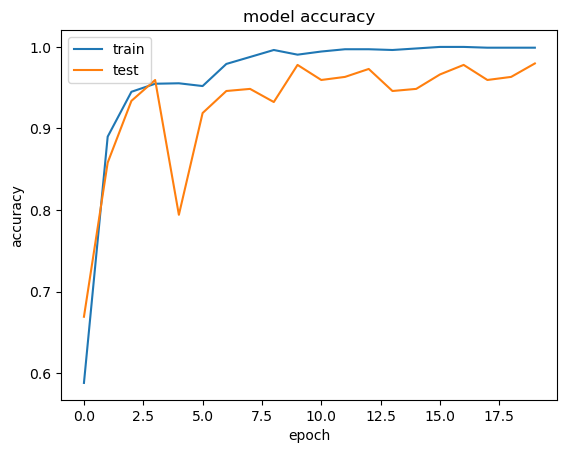

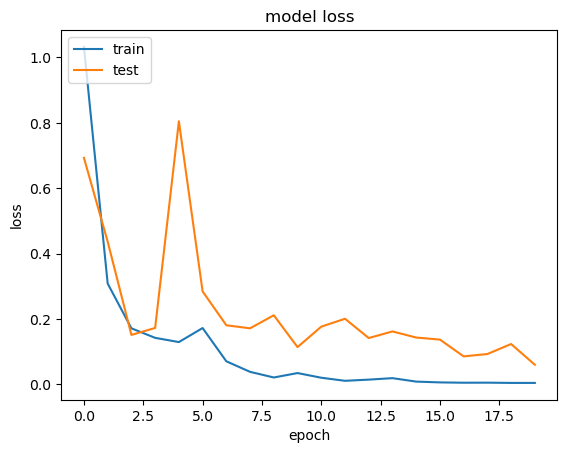

In [39]:
plot_loss_accuracy(history)

## Observations

Experiment | Model Config | Categorical Accuracy | Validation Accuracy
-----:|:-------------------------: | :---------------: | :---------------
1 | Conv3D (3 layers) | 96.68% | 57.00%
2 | Conv2D + TimeDistributed + GRU | 81.60% | 31.00%
3 | Conv2D + TimeDistributed + GlobalAveragePooling2D | 75.72% | 39.00%
4 | Conv3D + LSTM | 96.53% | 54.00%
5 | Conv3D (4 layers) | 97.59% | 53.00%
6 | Transfer Learning (MobileNet) + TimeDistributed + LSTM + GRU |  99.91% | 98.53%